In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('drive/My Drive/Colab Notebooks/models')

In [3]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/models'

In [4]:
!pip install gluonnlp
!pip install mxnet
!pip install leven
!pip install mxboard
!pip install nltk==3.2.5
!pip install sacremoses
import nltk
nltk.download('perluniprops')
nltk.download('nonbreaking_prefixes')

     |████████████████████████████████| 245kB 4.9MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.8.2-cp36-none-any.whl size=293515 sha256=1c161aeb32c35ba5ea9fdc9e36d7342e2edff82bb3c24bc6531c18ba0753abfe
  Stored in directory: /root/.cache/pip/wheels/a4/aa/61/0aebc5c078c4b1ccf325cd7579932b99403008da6e7ce6b68f
Successfully built gluonnlp
     |████████████████████████████████| 25.4MB 118kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 163kB 6.7MB/s 
  Created wheel for leven: filename=leven-1.0.4-cp36-cp36m-linux_x86_64.whl size=54680 sha256=62a39531738548c87a43f0389b514453093dd5a4011e35d45d361e6c4050c056
  Stored in directory: /root/.cache/pip/wheels/54/64/a5/439db671d666a50f3b3cebd2dcab3fbbab02785adf58e47552
Successfully built leven
     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 870kB 5.0MB/s 
  Created wheel

True

In [0]:
import difflib
import importlib
import math
import cv2 as cv2
import numpy as np
import mxnet as mx
import random
import matplotlib.pyplot as plt
import gluonnlp as nlp
import leven
import matplotlib.patches as patches
from skimage import transform as skimage_tf, exposure
from tqdm import tqdm


In [0]:


from ocr.utils.expand_bounding_box import expand_bounding_box
from ocr.utils.sclite_helper import ScliteHelper
from ocr.utils.word_to_line import sort_bbs_line_by_line, crop_line_images
from ocr.utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from ocr.utils.encoder_decoder import Denoiser, ALPHABET, encode_char, decode_char, EOS, BOS
from ocr.utils.beam_search import ctcBeamSearch

import ocr.utils.denoiser_utils
import ocr.utils.beam_search

importlib.reload(ocr.utils.denoiser_utils)
from ocr.utils.denoiser_utils import SequenceGenerator

importlib.reload(ocr.utils.beam_search)
from ocr.utils.beam_search import ctcBeamSearch



from ocr.paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform
from ocr.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from ocr.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding


In [0]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()


In [0]:
def resize_image(image, desired_size):
    ''' Helper function to resize an image while keeping the aspect ratio.
    Parameter
    ---------
    
    image: np.array
        The image to be resized.

    desired_size: (int, int)
        The (height, width) of the resized image

    Return
    ------

    image: np.array
        The image of size = desired_size

    bounding box: (int, int, int, int)
        (x, y, w, h) in percentages of the resized image of the original
    '''
    size = image.shape[:2]
    if size[0] > desired_size[0] or size[1] > desired_size[1]:
        ratio_w = float(desired_size[0])/size[0]
        ratio_h = float(desired_size[1])/size[1]
        ratio = min(ratio_w, ratio_h)
        new_size = tuple([int(x*ratio) for x in size])
        image = cv2.resize(image, (new_size[1], new_size[0]))
        size = image.shape
            
    delta_w = max(0, desired_size[1] - size[1])
    delta_h = max(0, desired_size[0] - size[0])
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
            
    color = image[0][0]
    if color < 230:
        color = 230
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=float(color))
    crop_bb = (left/image.shape[1], top/image.shape[0], (image.shape[1] - right - left)/image.shape[1],
               (image.shape[0] - bottom - top)/image.shape[0])
    image[image > 230] = 255
    return image, crop_bb




MAX_IMAGE_SIZE_FORM = (1120, 800)
MAX_IMAGE_SIZE_LINE = (60, 800)
MAX_IMAGE_SIZE_WORD = (30, 140)


#this function takes in the img file path
def _pre_process_image(img_in,_parse_method):
    im = cv2.imread(img_in, cv2.IMREAD_GRAYSCALE)
    if np.size(im) == 1: # skip if the image data is corrupt.
        return None
    # reduce the size of form images so that it can fit in memory.
    if _parse_method in ["form", "form_bb"]:
        im, _ = resize_image(im, MAX_IMAGE_SIZE_FORM)
    if _parse_method == "line":
        im, _ = resize_image(im, MAX_IMAGE_SIZE_LINE)
    if _parse_method == "word":
        im, _ = resize_image(im, MAX_IMAGE_SIZE_WORD)
    img_arr = np.asarray(im)
    return img_arr


In [0]:


img = _pre_process_image('a01-000u.png','form')
test_ds = []


In [0]:
test_ds.append(img)
test_ds.append(img)
test_ds.append(img)
test_ds.append(img)

In [11]:
len(test_ds)

4

In [0]:
random.seed(1)


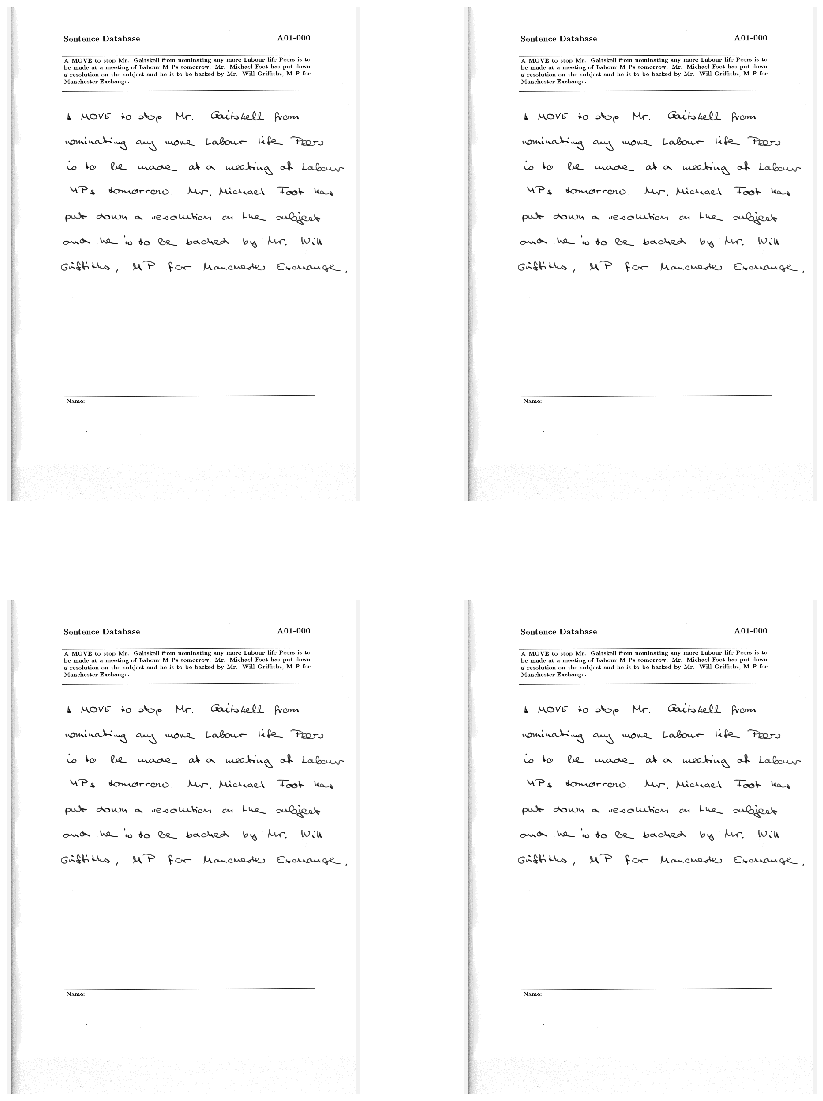

In [13]:
figs_to_plot = 4
images = []

n = 0
for i in range(0, figs_to_plot):
    n = int(random.random()*len(test_ds))
    image = test_ds[n]
    images.append(image)
    
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')


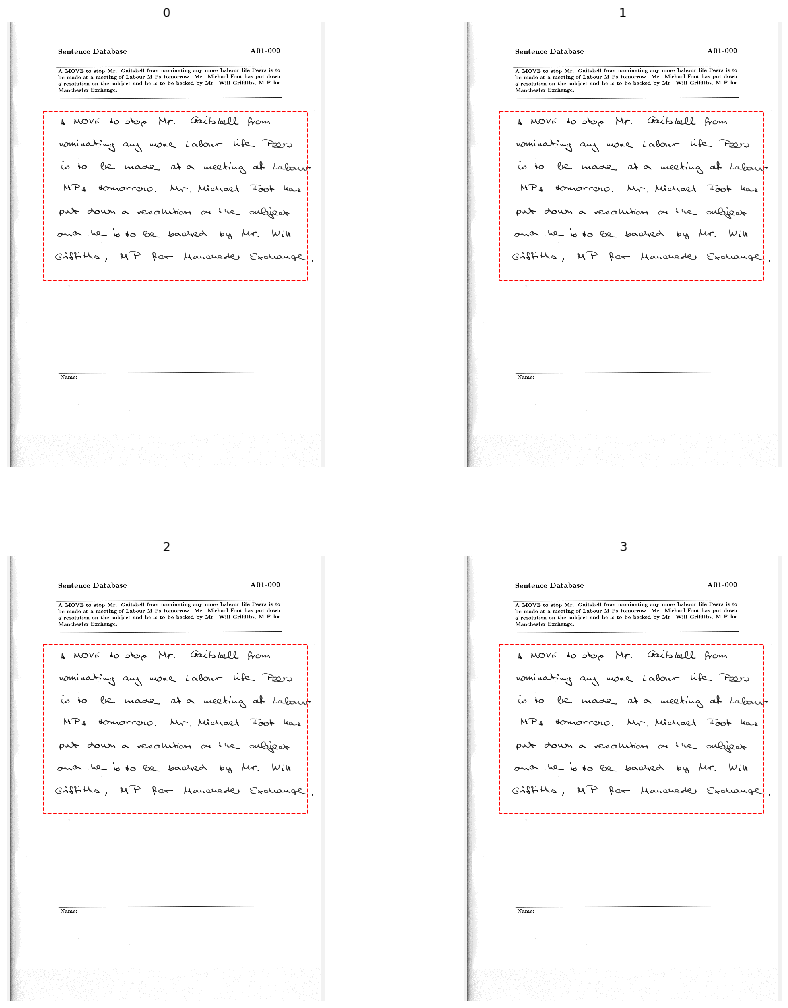

In [14]:
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
paragraph_segmentation_net.cnn.load_parameters("models/paragraph_segmentation2.params", ctx=ctx)

paragraph_segmentation_net.hybridize()    


form_size = (1120, 800)


predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    bb_predicted = bb_predicted[0].asnumpy()
    bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03,
                                           expand_bb_scale_y=0.03)
    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].set_title("{}".format(i))

    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')


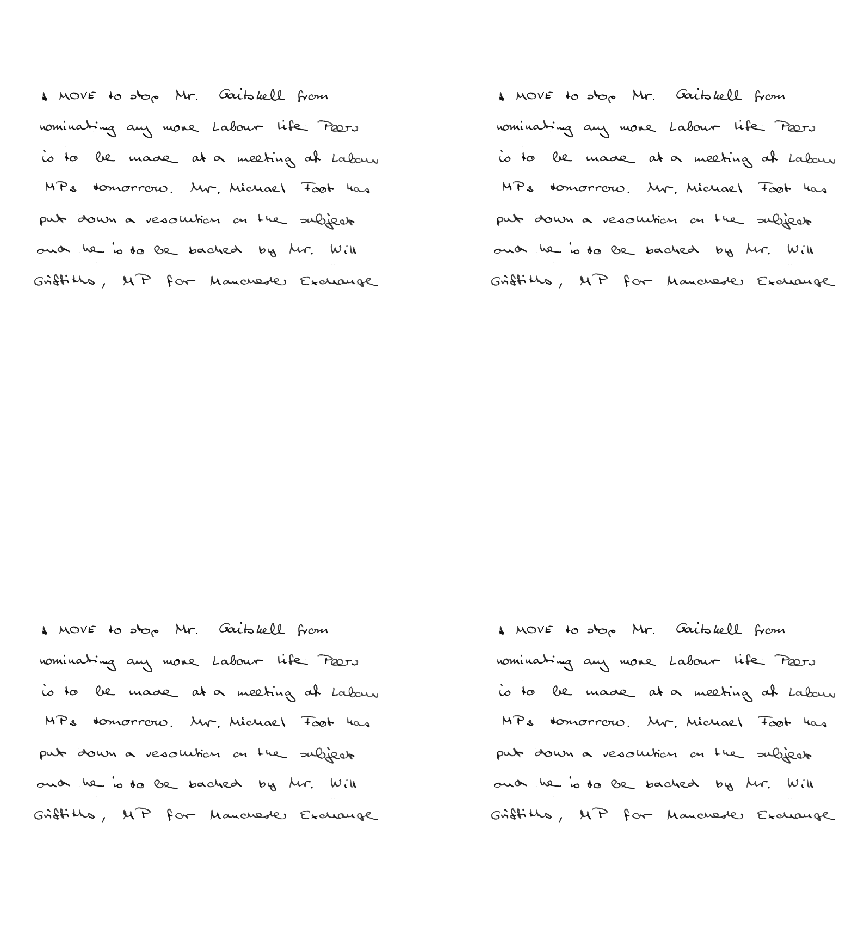

In [15]:

segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')


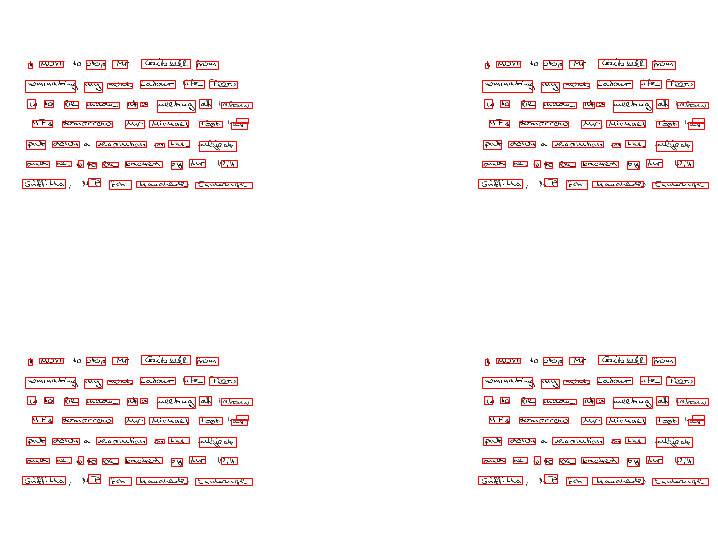

In [16]:

word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation2.params")
word_segmentation_net.hybridize()


min_c = 0.1
overlap_thres = 0.1
topk = 600

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

    predicted_words_bbs_array.append(predicted_bb)
    
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    for j in range(predicted_bb.shape[0]):     
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')


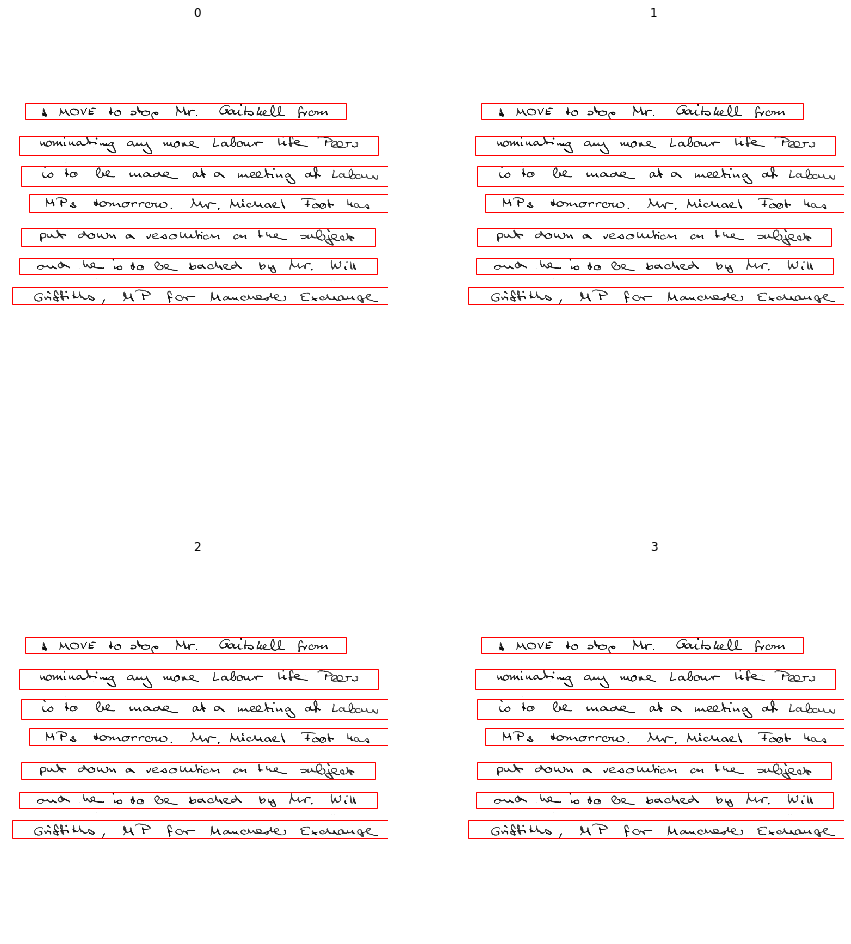

In [17]:
line_images_array = []
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    axs[s_y, s_x].set_title("{}".format(i))
    
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    line_images_array.append(line_images)
    
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)


In [0]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line8.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()


line_image_size = (60, 800)
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)


In [0]:

def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

def get_beam_search(prob, width=5):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width)
    return possibilities[0]


In [0]:
FEATURE_LEN = 150
denoiser = Denoiser(alphabet_size=len(ALPHABET), max_src_length=FEATURE_LEN, max_tgt_length=FEATURE_LEN, num_heads=16, embed_size=256, num_layers=2)
denoiser.load_parameters('models/denoiser2.params', ctx=ctx)

denoiser.hybridize(static_alloc=True)


In [0]:
ctx_nlp = mx.cpu(0)
language_model, vocab = nlp.model.big_rnn_lm_2048_512(dataset_name='gbw', pretrained=True,ctx=ctx_nlp)
moses_tokenizer = nlp.data.SacreMosesTokenizer()
moses_detokenizer = nlp.data.SacreMosesDetokenizer()


In [0]:

beam_sampler = nlp.model.BeamSearchSampler(beam_size=20,
                                           decoder=denoiser.decode_logprob,
                                           eos_id=EOS,
                                           scorer=nlp.model.BeamSearchScorer(),
                                           max_length=150)


generator = SequenceGenerator(beam_sampler, language_model, vocab, ctx_nlp, moses_tokenizer, moses_detokenizer)


In [0]:

def get_denoised(prob, ctc_bs=False):
    if ctc_bs: # Using ctc beam search before denoising yields only limited improvements a is very slow
        text = get_beam_search(prob)
    else:
        text = get_arg_max(prob)
    src_seq, src_valid_length = encode_char(text)
    src_seq = mx.nd.array([src_seq], ctx=ctx)
    src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
    encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
    states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                      encoder_valid_length=src_valid_length)
    inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
    output = generator.generate_sequences(inputs, states, text)
    return output.strip()



In [28]:
sentence = "This sentnce has an eror"
src_seq, src_valid_length = encode_char(sentence)
src_seq = mx.nd.array([src_seq], ctx=ctx)
src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                  encoder_valid_length=src_valid_length)
inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
print(sentence)
print("Choice")
print(generator.generate_sequences(inputs, states, sentence))


This sentnce has an eror
Choice
T h i s   s e n t e n c e 


[AM] I move to stop Mr. Gaitskell from
[D ] I move to stop Mr. Gaitskell from
[AM] nominating any more Labour life Peers
[D ] nominating any more Labour life Peers
[AM] is to be made at a meeting of Labour
[D ] is to be made at a meeting of Labour
[AM] MPs tomorrow. Mr. Michael Foot has
[D ] MPs tomorrow. Mr. Michael Foot has
[AM] put down a resouution on the subject
[D ] p u t   d o w n   a   r e s o l u t i
[AM] and he is to be backed by Mr. Will
[D ] and he is to be backed by Mr. Will
[AM] Gritfiths, M P for Mancheser Exchange
[D ] G r e a t   f i g h t s ,   I   a m   f
[AM] I move to stop Mr. Gaitskell from
[D ] I move to stop Mr. Gaitskell from
[AM] nominating any more Labour life Peers
[D ] nominating any more Labour life Peers
[AM] is to be made at a meeting of Labour
[D ] is to be made at a meeting of Labour
[AM] MPs tomorrow. Mr. Michael Foot has
[D ] MPs tomorrow. Mr. Michael Foot has
[AM] put down a resouution on the subject
[D ] p u t   d o w n   a   r e s o l u t i
[AM] a

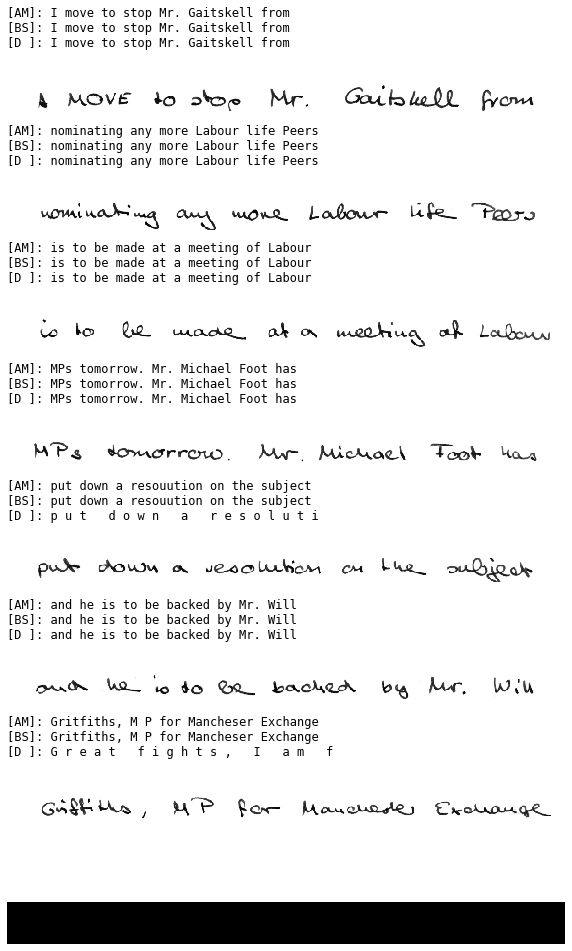

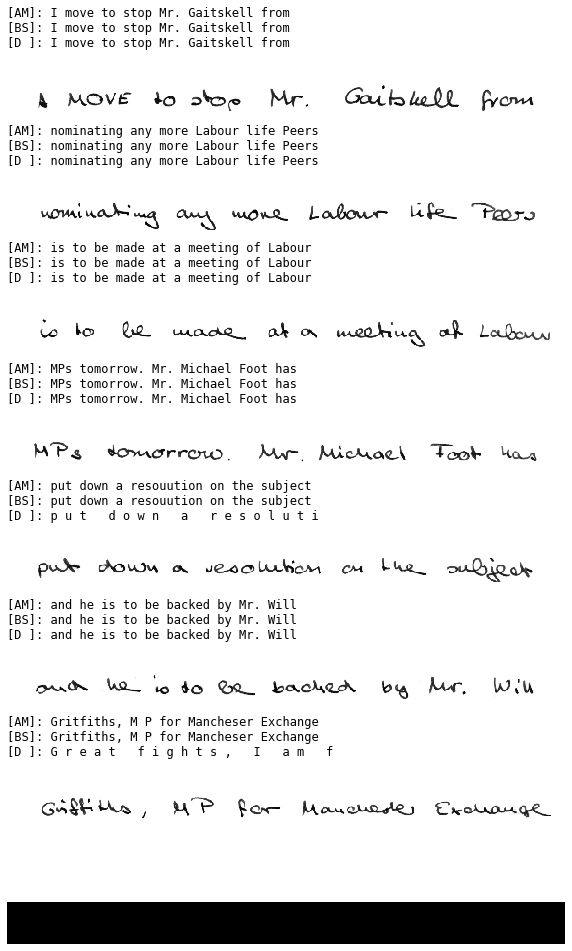

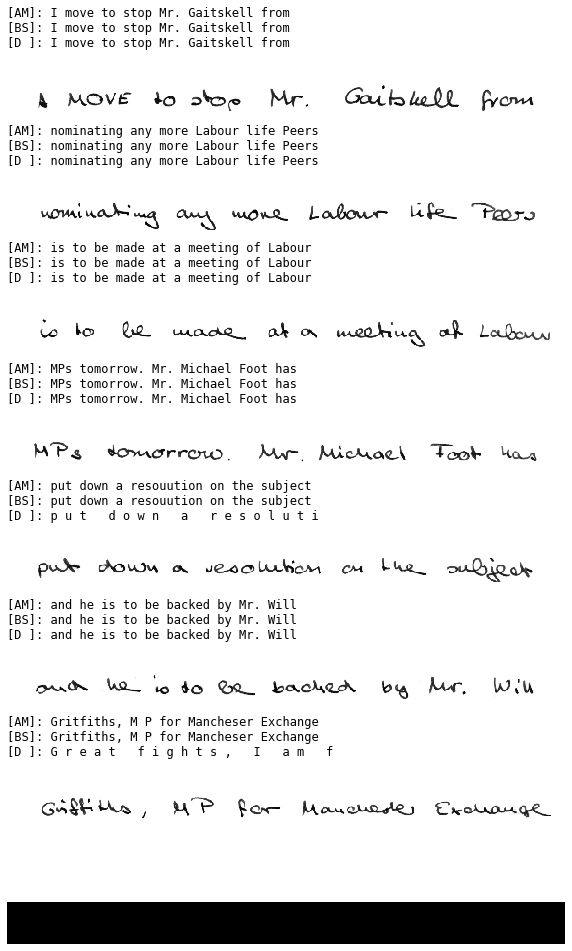

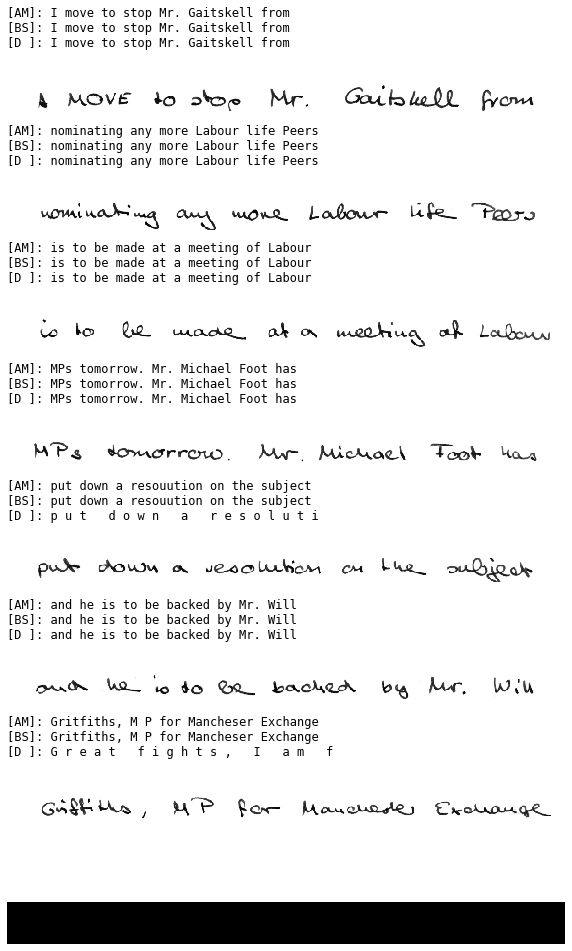

In [29]:

for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(10, int(1 + 2.3 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_am = get_arg_max(line_character_probs)
        print("[AM]",decoded_line_am)
        decoded_line_bs = get_beam_search(line_character_probs)
        decoded_line_denoiser = get_denoised(line_character_probs, ctc_bs=False)
        print("[D ]",decoded_line_denoiser)
        
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].set_title("[AM]: {}\n[BS]: {}\n[D ]: {}\n\n".format(decoded_line_am, decoded_line_bs, decoded_line_denoiser), fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')
